# Bayesian Modelling on Wine and Mushroom Datasets

##  Dataset loading and initial preprocessing

In [2]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif
from matplotlib import pyplot
from sklearn.metrics import classification_report, accuracy_score, make_scorer, precision_score, recall_score, f1_score


In [3]:
# Functions for binning (discreetising) numeric fields

def distance_binning(dataset, field, no_of_bins):
    
    # Buckets numerical field data into equally sized bucket thresholds
    # Returns updated dataframe
    
    # Inputs: 
    #    dataset:     Pandas dataframe containing dataset 
    #    field:       Field to be binned
    #    no_of_bins:  Required number of bins
    
    bins = np.linspace(dataset[field].min(),dataset[field].max(),no_of_bins+1)
    labels = [i for i in range(1,no_of_bins+1)]
    dataset_new = dataset.copy()
    dataset_new[field] = pd.cut(dataset_new[field], bins=bins, labels=labels, include_lowest=True)
    return dataset_new

def frequency_binning(dataset, field, no_of_bins):
    
    # Buckets numerical field data into buckets containing roughly equal number of records
    # Returns updated dataframe
    
    # Inputs: 
    #    dataset:     Pandas dataframe containing dataset 
    #    field:       Field to be binned
    #    no_of_bins:  Required number of bins
    
    labels = [i for i in range(1,no_of_bins+1)]
    dataset_new = dataset.copy()
    dataset_new[field] = pd.qcut(dataset_new[field], q=no_of_bins, labels=labels, duplicates= 'drop')
    return dataset_new


# Normalises the dataset
# you have to remove all non-numerical columns before you call this function
# data : the dataset you want to normalise 
# omit : colums to omit from the normalisation (as a 1d list)
def NormaliseDS(data, omit=[]):
    data = data.reset_index(drop=True)
    if (len(omit)>0):
        temp = data[omit]
        data = data.drop(columns=omit, axis=1)
    column = list(data.columns)
    transform = MinMaxScaler().fit_transform(data)
    newDF = pd.DataFrame(transform, columns=column)
    if (len(omit)>0):
        dataF = pd.concat([newDF, temp], axis=1)
        return(dataF)
    else:
        return(newDF)

# standardises the dataset
# you have to remove all non-numerical columns before you call this function
# data : the dataset you want to standardise
def StandardiseDS(data, omit=[]):
    data = data.reset_index(drop=True)
    if (len(omit)>0):
        temp = data[omit]
        data = data.drop(columns=omit, axis=1)
    column = list(data.columns)
    strdDS = StandardScaler().fit_transform(data)
    strdDF = pd.DataFrame(strdDS, columns=column)
    if (len(omit)>0):
        dataF = pd.concat([strdDF, temp], axis=1)
        return(dataF)
    else:
        return(strdDF)

# renames the column names in a dataset so it is one word instead of a space
# data : the dataset you want to rename 
# cols : a dictionary of the current columns you want to rename and the name you want to rename it to (new name should have no spaces)
def RenameFields(data, cols):
    data2 = data.rename(columns=cols)
    return(data2)

# this fucntion divides the possible results of the dataset (ie the quality of a wine) and up-samples the dataset so the data is balanced
# dataset (dataframe) : the dataset you want to up-sample
# targetClass (string) : the name of the column that has the results
# startPoint (int) : the lowest class by number in the dataset(for wine lowest quality is 3, Highest quality is 9 )
# biggestClass (int) : the class that has the highest number of rows
def OverSample (dataset, targetClass, startPoint, biggestClass):
    temp = []
    temp2 = []
    loopRange = (startPoint + len(dataset[targetClass].value_counts()))
    for i in range(startPoint, loopRange):
        temp.append(dataset[dataset[targetClass] == i])
    for j in temp:
        temp2.append(j.sample(len(temp[(biggestClass-startPoint)]), replace=True))
        
    final = pd.concat(temp2)
    return(final)


In [4]:
# Loads the datasets
wine = pd.read_csv('winequalityN.csv')
mushrooms = pd.read_csv('mushrooms.csv')

# renames the columns
dsCols = {'fixed acidity': 'fixed-acidity', 'volatile acidity': 'volatile-acidity', 'citric acid': 'citric-acid', 'residual sugar':'residual-sugar', 'free sulfur dioxide':'free-sulfur-dioxide', 'total sulfur dioxide':'total-sulfur-dioxide'}
wine = RenameFields(wine, dsCols)

################ NULL Checks ################
print(mushrooms.isnull().sum())
print(wine.isnull().sum())
# removes rows with null values
wine = wine.dropna()


mushroomsTemp = mushrooms['class'].replace(['p', 'e'],[1, 0])
mushrooms.drop('class', inplace=True, axis=1)
mushrooms = pd.concat([mushrooms, mushroomsTemp], axis=1)
print(mushrooms)

################ Normalisation and Standardisation ################

# temp removes the worded fields
wineTemp = wine['type'].replace(['white', 'red'],[1, 0])   # binary encodes white and red wine types (white=1, red=0)
wine.drop('type', inplace=True, axis=1)
wine = pd.concat([wine, wineTemp], axis=1)
print(wine)

#normalises the dataset (omit is used to remove colums that do not need to be normalised ie bool, one hot, etc)
normalwine = NormaliseDS(wine, omit=['quality', 'type'])
#standardises the dataset (omit is used to remove colums that do not need to be normalised ie bool, one hot, etc)
standardwine = StandardiseDS(normalwine, omit=['quality', 'type'])
print("standard")
print(standardwine)


################ Balancing ################                COULD ALSO TRY BUCKTING TO BALANCE THE DATA

# prints the distribution of wine quality (quality is between 3 and 9, has most of the wines inbetween )
print(standardwine.quality.value_counts())      # Doing this we can see that the lowest quality is 3 (so that is the startPoint), and the class with the most rows is 6 (so 6 is the biggestClass)

balancedDataWine = OverSample(standardwine, 'quality', startPoint=3, biggestClass=6)
print(balancedDataWine.quality.value_counts())     # we can now see that the results are up Sampled to match the biggest dataset

# balancing for mushroom dataset (MUSHROOMS IS ALREADY KINDA BALANCED)
print(mushrooms['class'].value_counts())      # dataset is already balanced enough
 


    
############### Mushroom Dataset Encoding ###############
# list of headinds that need to be one hot encoded
prefixList = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'gill-attachment', 'gill-spacing', 'gill-size', 
              'gill-color', 'stalk-shape', 'stalk-root','odor', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 
              'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 
              'spore-print-color', 'population', 'habitat']

# veil-type column is not taken forward because each row has the same values making it useless for the models
mushroomsNew = mushrooms['class'] # the first enoded column (poisonus = 1, edible = 2)
# loop to convert onehot for all relevent 
for pref in prefixList:
    tempEncode = pd.get_dummies(mushrooms[pref], prefix=pref)
    mushroomsNew = pd.concat([mushroomsNew, tempEncode], axis=1)
print(mushroomsNew.head())

balancedDataWine = balancedDataWine.dropna()
standardwine = standardwine.dropna()
normalwine = normalwine.dropna()

# saves new datasets
mushroomsNew.to_csv('newMushroom.csv', index=False)
balancedDataWine.to_csv('newWine.csv', index=False)


class                       0
cap-shape                   0
cap-surface                 0
cap-color                   0
bruises                     0
odor                        0
gill-attachment             0
gill-spacing                0
gill-size                   0
gill-color                  0
stalk-shape                 0
stalk-root                  0
stalk-surface-above-ring    0
stalk-surface-below-ring    0
stalk-color-above-ring      0
stalk-color-below-ring      0
veil-type                   0
veil-color                  0
ring-number                 0
ring-type                   0
spore-print-color           0
population                  0
habitat                     0
dtype: int64
type                     0
fixed-acidity           10
volatile-acidity         8
citric-acid              3
residual-sugar           2
chlorides                2
free-sulfur-dioxide      0
total-sulfur-dioxide     0
density                  0
pH                       9
sulphates                4


[5 rows x 117 columns]


In [5]:
#Function to perform distance binning on all fields in a dataframe not in ignore with a bin size of bins
def distance_bin_df(df, bins, ignore):
    binned_df = df
    for field in binned_df.columns:
        if not field in ignore:
            binned_df = distance_binning(binned_df, field, bins)   
    return binned_df

#Function to perform frequency binning on all fields in a dataframe not in ignore with a bin size of bins
def frequency_bin_df(df, bins, ignore):
    binned_df = df
    for field in binned_df.columns:
        if not field in ignore:
            binned_df = frequency_binning(binned_df, field, bins)
    return binned_df


In [6]:
#Create baseline binned datasets for the wine dataset with bin widths of 10.
wine_distance_binned = distance_bin_df(wine,10,['quality','type'])
wine_frequency_binned = frequency_bin_df(wine,10,['quality','type'])

## Wine Dataset
This first experiment tests different preprocessing methods for each of our selected Naive Bayes models.

In [7]:
#Define the datasets to be used in the test. This test tests raw, standardised, normalise, balanced, distance binned and frequency binned data.
datasets = []
datasets.append(("Raw values",wine))
datasets.append(("Standardised",standardwine))
datasets.append(("Normalised",normalwine))
datasets.append(("Balanced",balancedDataWine))
datasets.append(("Distance binned",wine_distance_binned))
datasets.append(("Frequency binned",wine_frequency_binned))


In [8]:
#Define the models to be used. In this case, Multinomial, Gaussian and Bernoulli Naive Bayes
models = []
models.append(('MultinomialNB', MultinomialNB()))
models.append(('GaussianNB', GaussianNB()))
models.append(('BernoulliNB', BernoulliNB()))

Dataset: Raw values
Accuracy (MultinomialNB): 0.381266 (0.024191)
F1 Weighted (MultinomialNB): 0.377987 (0.019927)
Accuracy (GaussianNB): 0.402300 (0.025027)
F1 Weighted (GaussianNB): 0.417545 (0.021731)
Accuracy (BernoulliNB): 0.440890 (0.024651)
F1 Weighted (BernoulliNB): 0.364393 (0.024561)


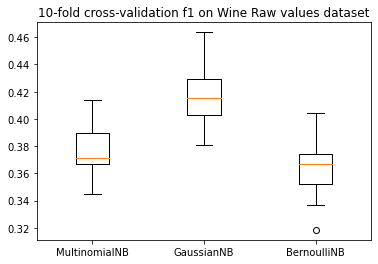

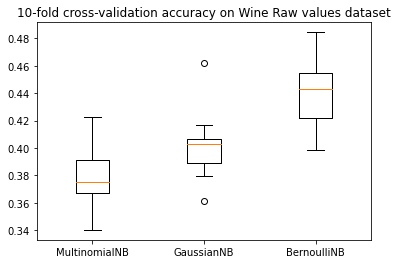

Dataset: Standardised
Accuracy (MultinomialNB): nan (nan)
F1 Weighted (MultinomialNB): nan (nan)
Accuracy (GaussianNB): 0.365987 (0.030190)
F1 Weighted (GaussianNB): 0.393311 (0.023913)
Accuracy (BernoulliNB): 0.445423 (0.024864)
F1 Weighted (BernoulliNB): 0.427998 (0.025014)


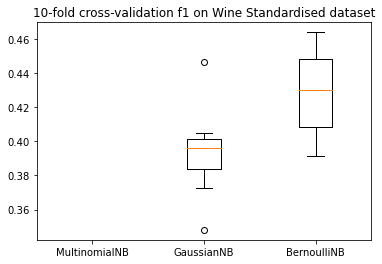

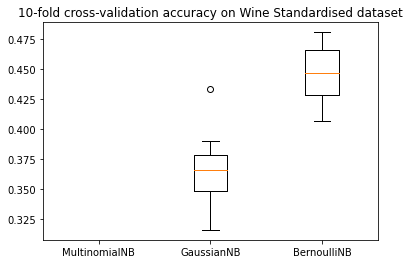

Dataset: Normalised
Accuracy (MultinomialNB): 0.433054 (0.003392)
F1 Weighted (MultinomialNB): 0.264875 (0.004655)
Accuracy (GaussianNB): 0.358767 (0.031333)
F1 Weighted (GaussianNB): 0.388482 (0.024822)
Accuracy (BernoulliNB): 0.441716 (0.025420)
F1 Weighted (BernoulliNB): 0.366054 (0.025305)


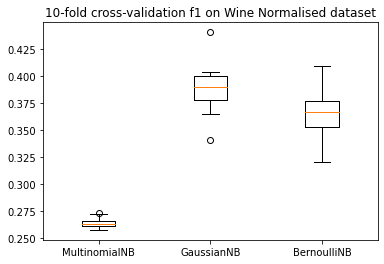

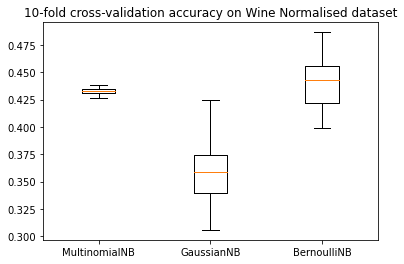

Dataset: Balanced
Accuracy (MultinomialNB): nan (nan)
F1 Weighted (MultinomialNB): nan (nan)
Accuracy (GaussianNB): 0.341776 (0.010159)
F1 Weighted (GaussianNB): 0.290332 (0.009355)
Accuracy (BernoulliNB): 0.303005 (0.007171)
F1 Weighted (BernoulliNB): 0.274149 (0.005527)


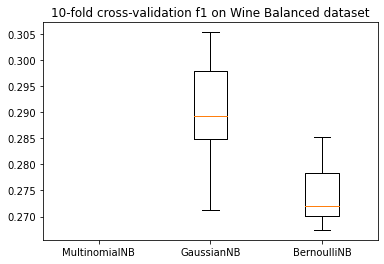

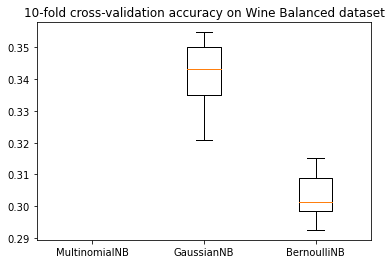

Dataset: Distance binned
Accuracy (MultinomialNB): 0.505873 (0.016789)
F1 Weighted (MultinomialNB): 0.440808 (0.016600)
Accuracy (GaussianNB): 0.315642 (0.053395)
F1 Weighted (GaussianNB): 0.365997 (0.033322)
Accuracy (BernoulliNB): 0.440890 (0.024651)
F1 Weighted (BernoulliNB): 0.364393 (0.024561)


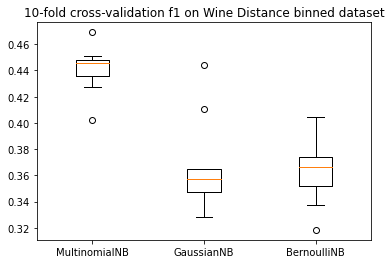

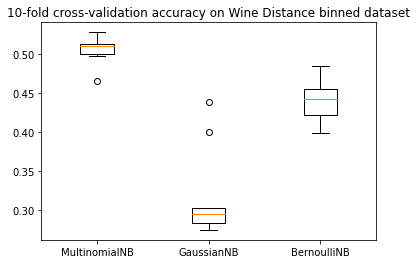

Dataset: Frequency binned
Accuracy (MultinomialNB): 0.459666 (0.013964)
F1 Weighted (MultinomialNB): 0.456273 (0.011327)
Accuracy (GaussianNB): 0.416739 (0.026349)
F1 Weighted (GaussianNB): 0.418223 (0.022570)
Accuracy (BernoulliNB): 0.440890 (0.024651)
F1 Weighted (BernoulliNB): 0.364393 (0.024561)


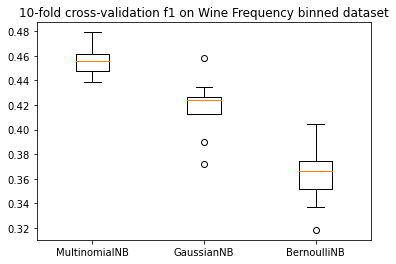

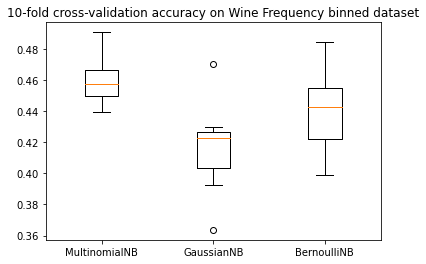

In [9]:
#Iterate over each dataset
for dsname, ds in datasets:
    print("Dataset: " + dsname)
    
    #Wine dataset, so our target is 'quality'
    X = ds.drop(['quality'], axis=1)
    y = ds['quality']
    
    #Train test split of 75/25
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)
    
    #Iterate over each model in the test and calculate the f1 score and accuracy using 10 fold cross validation.
    #Keep track of the best f1-weighted score and accuracy to print and store f1 scores to plot. 
    f1_results = []
    accuracy_results = []
    names = []
    for name, model in models:
        kfold = StratifiedKFold(n_splits=10, random_state=1)
        results = cross_validate(model, X_train, Y_train, cv=kfold, scoring = {'accuracy' : make_scorer(accuracy_score),
           'f1_score' : make_scorer(f1_score, average = 'weighted')})
        
        cv_f1_results = results['test_f1_score']
        cv_accuracy_results = results['test_accuracy']

        accuracy_results.append(cv_accuracy_results)
        f1_results.append(cv_f1_results)
        
        names.append(name)
        print('Accuracy (%s): %f (%f)' % (name, cv_accuracy_results.mean(), cv_accuracy_results.std()))
        print('F1 Weighted (%s): %f (%f)' % (name, cv_f1_results.mean(), cv_f1_results.std()))

        
    # Plot f1 and accuracy scores for each dataset and model
    pyplot.boxplot(f1_results, labels=names)
    pyplot.title('10-fold cross-validation f1 on Wine ' + dsname + ' dataset')
    pyplot.show()
    
    pyplot.boxplot(accuracy_results, labels=names)
    pyplot.title('10-fold cross-validation accuracy on Wine ' + dsname + ' dataset')
    pyplot.show()

## Bin size test for Multinomial Naive Bayes model
The best preprocessing method found for Multinomial Bayes above was the frequency binning method. As such, we can optimise this pre-processing by determining the optimal bin size. 

In [10]:
#Test bin sizes 1-20
binsize_tests = range(1,21)

#Train Multinomial models using 10 fold cross validation for each variant of bin size and store the optimal values
#for bin size and the corresponsing f1 score. 
best_f1 = np.zeros(1)
best_binsize = 0
results = []
for i, binsize in enumerate(binsize_tests):
    ds = frequency_bin_df(wine,binsize,['quality','type'])
    X = ds.drop(['quality'], axis=1)
    y = ds['quality']
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)

    kfold = StratifiedKFold(n_splits=10, random_state=1)
    f1 = cross_val_score(MultinomialNB(), X_train, Y_train, cv=kfold, scoring='f1_weighted')
    
    if f1.mean()>best_f1.mean():
        best_f1 = f1
        best_binsize = binsize
    
    results.append(f1.mean())

print("Optimal binsize found at " + str(best_binsize) + " for Multinomial Naive Bayes. Obtained f1 weighted score: " + str(best_f1.mean()) + " (" + str(best_f1.std()) + ")")


Optimal binsize found at 6 for Multinomial Naive Bayes. Obtained f1 weighted score: 0.48447402834194264 (0.018911396658901233)


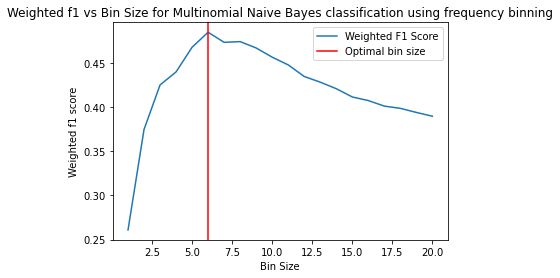

In [11]:
#Plot the results of the previous test to show how f1 score changes with bin size
x = binsize_tests
y = results

plt.figure()
plt.plot(x, y, label='Weighted F1 Score')  
plt.axvline(x=best_binsize, color = 'r', label='Optimal bin size')

plt.xlabel("Bin Size")
plt.ylabel("Weighted f1 score")
plt.title("Weighted f1 vs Bin Size for Multinomial Naive Bayes classification using frequency binning")
plt.legend()
plt.show()

## Bin size test for Gaussian Naive Bayes model
The best preprocessing method found for Multinomial Bayes above was the frequency binning method. As such, we can optimise this pre-processing by determining the optimal bin size. 

In [12]:
#Test bin sizes 1-20
binsize_tests = range(1,21)

#Train Gaussian models using 10 fold cross validation for each variant of bin size and store the optimal values
#for bin size and the corresponsing f1 score. 
best_f1 = np.zeros(1)
best_binsize = 0
results = []
for i, binsize in enumerate(binsize_tests):
    ds = frequency_bin_df(wine,binsize,['quality','type'])
    X = ds.drop(['quality'], axis=1)
    y = ds['quality']
    X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)

    kfold = StratifiedKFold(n_splits=10, random_state=1)
    f1 = cross_val_score(GaussianNB(), X_train, Y_train, cv=kfold, scoring='f1_weighted')
    
    if f1.mean()>best_f1.mean():
        best_f1 = f1
        best_binsize = binsize
    
    results.append(f1.mean())

print("Optimal binsize found at " + str(best_binsize) + " for Gaussian Naive Bayes. Obtained f1 weighted score: " + str(best_f1.mean()) + " (" + str(best_f1.std()) + ")")


Optimal binsize found at 17 for Gaussian Naive Bayes. Obtained f1 weighted score: 0.42899724886398694 (0.022306125015154804)


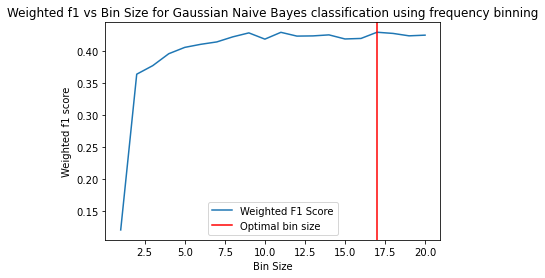

In [13]:
x = binsize_tests
y = results

plt.figure()
plt.plot(x, y, label='Weighted F1 Score')  
plt.axvline(x=best_binsize, color = 'r', label='Optimal bin size')

plt.xlabel("Bin Size")
plt.ylabel("Weighted f1 score")
plt.title("Weighted f1 vs Bin Size for Gaussian Naive Bayes classification using frequency binning")
plt.legend()
plt.show()

## Feature selection
The following feature selection function using chi-squared and mutual information models was adapted from https://machinelearningmastery.com/feature-selection-with-categorical-data/ with tweaks to allow for the returning of selected feature names. The function fits a feature selection model to the train dataset to determine the most important features to the classification. The most important features are saved and the resulting dataset is transformed to only use those n most important features. 

In [14]:
#Feature selection. Reads in the train and test data as well as the score function and the number of features to keep.
#Returns transformed train and test arrays with features removed. 
def select_features(X_train, y_train, X_test, score_func, n_features):
    fs = SelectKBest(score_func=score_func, k=n_features)
    fs.fit(X_train, y_train)
    X_train_fs = fs.transform(X_train)
    X_test_fs = fs.transform(X_test)
    mask = fs.get_support()
    selected_feature_names = []
    for i, feature in enumerate(mask):
        if feature:
            selected_feature_names.append(X_train.columns[i])
    
    return X_train_fs, X_test_fs, selected_feature_names

Best features found for MultinomialNB using Chi-Squared feature selection: volatile-acidity chlorides density alcohol.
F1 Score: 0.48741930470426426 (0.02375347344039468)
Accuracy: 0.5124793388429751 (0.024281920884535714)


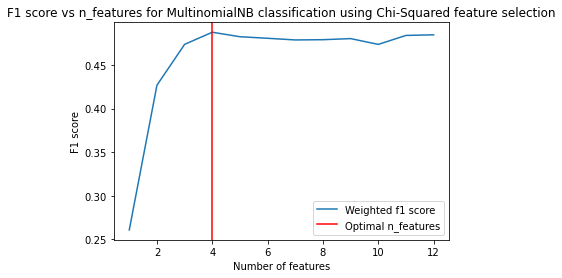

Best features found for MultinomialNB using Mutual Information feature selection: volatile-acidity chlorides density alcohol.
F1 Score: 0.48741930470426426 (0.02375347344039468)
Accuracy: 0.5124793388429751 (0.024281920884535714)


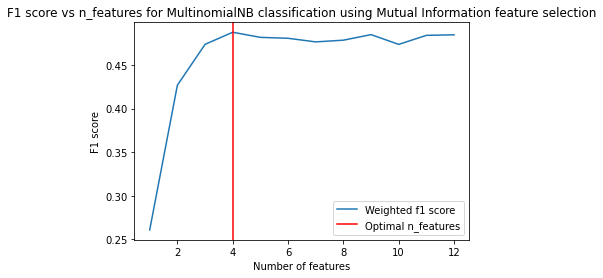

Best features found for GaussianNB using Chi-Squared feature selection: volatile-acidity citric-acid chlorides free-sulfur-dioxide density alcohol.
F1 Score: 0.4697578253976841 (0.01778985346191188)
Accuracy: 0.4918437420124393 (0.018318565533160545)


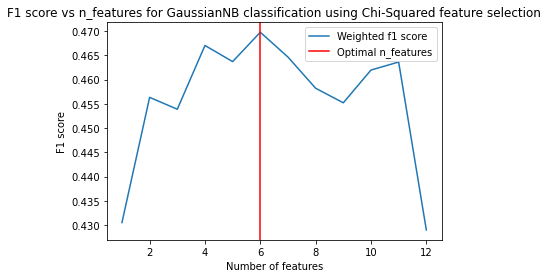

Best features found for GaussianNB using Mutual Information feature selection: volatile-acidity citric-acid chlorides density alcohol.
F1 Score: 0.46989590013113436 (0.017586332937421775)
Accuracy: 0.4922578171594103 (0.018144901799641105)


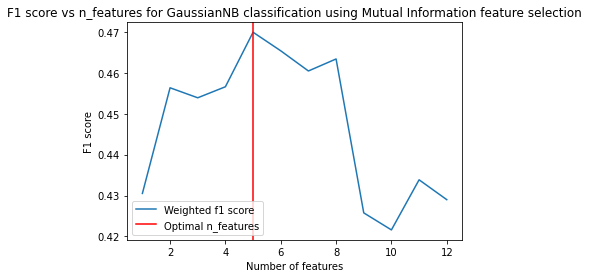

Best features found for BernoulliNB using Chi-Squared feature selection: volatile-acidity residual-sugar free-sulfur-dioxide total-sulfur-dioxide alcohol type.
F1 Score: 0.36439321224744203 (0.024560928069514022)
Accuracy: 0.44088992076339784 (0.024650675431022766)


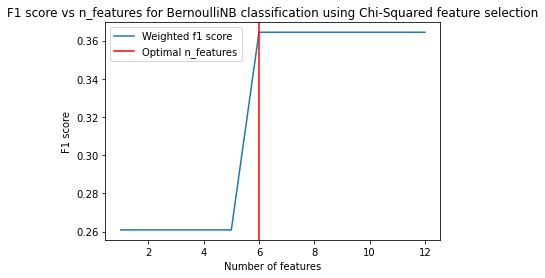

Best features found for BernoulliNB using Mutual Information feature selection: volatile-acidity citric-acid residual-sugar chlorides free-sulfur-dioxide total-sulfur-dioxide density sulphates alcohol type.
F1 Score: 0.36439321224744203 (0.024560928069514022)
Accuracy: 0.44088992076339784 (0.024650675431022766)


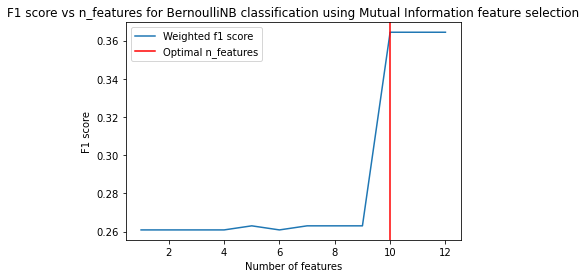

In [15]:
#Test using the most important 1-12 features, i.e 1 to all features in the wine dataset. 
feature_tests = range(1,13)

#Define the models to be tested. Since each model has been proven to function best with different pre-processing,
#that is also defined here.
models = []
models.append(('MultinomialNB', MultinomialNB(), frequency_bin_df(wine,6,['quality','type'])))
models.append(('GaussianNB', GaussianNB(), frequency_bin_df(wine,17,['quality','type'])))
models.append(('BernoulliNB', BernoulliNB(), wine))

#For this test the chi-squared model and mutual information model will be used for feature selection.
feature_selection_models = []
feature_selection_models.append(('Chi-Squared',chi2))
feature_selection_models.append(('Mutual Information',mutual_info_classif))

#Iterate over each model and respective dataset
for name, model, dataset in models:
    
    #Iterate over each feature selection model
    for fsname, fsmodel in feature_selection_models:
        
        #For each test, train models using 10 fold cross validation with between 1 and 12 features included 
        #and store the best obtained f1 score and accuracy to output to the user. 
        results = []
        best_f1 = np.zeros(1)
        best_accuracy = np.zeros(1)
        best_features = []
        for n_features in feature_tests:
            X = dataset.drop(['quality'], axis=1)
            y = dataset['quality']

            X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)
            X_train_fs, X_test_fs, features = select_features(X_train, Y_train, X_validation, fsmodel, n_features)
            kfold = StratifiedKFold(n_splits=10, random_state=1)
            scores = cross_validate(model, X_train_fs, Y_train, cv=kfold, scoring = {'accuracy' : make_scorer(accuracy_score), 
                   'f1_score' : make_scorer(f1_score, average = 'weighted')})

            f1 = scores['test_f1_score']
            accuracy = scores['test_accuracy']
            if f1.mean()>best_f1.mean():
                best_f1 = f1
                best_features = features
                best_accuracy = accuracy
                
            results.append((features,f1))

        #Print the best obtained metrics and the features used to achieve this. 
        print('Best features found for '+ name +' using '+  fsname+' feature selection: ' + " ".join(best_features) + ".")
        print('F1 Score: ' + str(best_f1.mean()) + " (" + str(best_f1.std()) + ")")
        print('Accuracy: ' + str(best_accuracy.mean()) + " (" + str(best_accuracy.std()) + ")")

        #Plot how the f1 score changes as the number of included features change.
        results = list(zip(*results))
        plot_x = list(range(1,13))
        plot_y = [x.mean() for x in results[1]]
        
        plt.figure()
        plt.plot(plot_x, plot_y, label='Weighted f1 score')  
        plt.axvline(x=len(best_features), color = 'r', label='Optimal n_features')

        plt.xlabel("Number of features")
        plt.ylabel("F1 score")
        plt.title("F1 score vs n_features for "+ name +" classification using "+ fsname +" feature selection")
        plt.legend()
        plt.show()

## Wine Testing
The following section evaluates each Naive Model using the optimised datasets and parameters for each using the test dataset. 

## Multinomial Naive Bayes

In [16]:
#Train a multinomial naive bayes model on the full train set using the optimised dataset and evaluate against the test set. 
model = MultinomialNB()
dataset = frequency_bin_df(wine,6,['quality','type'])
X = dataset.drop(['quality'], axis=1)
y = dataset['quality']
X = X[['volatile-acidity','chlorides','density', 'alcohol']]

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)

model.fit(X_train, Y_train)

y_pred = model.predict(X_validation)

f1 = f1_score(y_pred, Y_validation, average='weighted')
accuracy =  accuracy_score(y_pred, Y_validation) 

print('F1 Score: ' + str(f1))
print('Accuracy: ' + str(accuracy))


F1 Score: 0.5508954774738919
Accuracy: 0.5303217821782178


## Gaussian Naive Bayes

In [17]:
#Train a Gaussian naive bayes model on the full train set using the optimised dataset and evaluate against the test set. 
model = GaussianNB()
dataset = frequency_bin_df(wine,17,['quality','type'])
X = dataset.drop(['quality'], axis=1)
y = dataset['quality']
X = X[['volatile-acidity',
 'citric-acid',
 'chlorides',
 'free-sulfur-dioxide',
 'density',
 'alcohol']]

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)

model.fit(X_train, Y_train)

y_pred = model.predict(X_validation)

f1 = f1_score(y_pred, Y_validation, average='weighted')
accuracy =  accuracy_score(y_pred, Y_validation)   

print('F1 Score: ' + str(f1))
print('Accuracy: ' + str(accuracy))


F1 Score: 0.5323299483011799
Accuracy: 0.5136138613861386


## Bernoulli Naive Bayes

In [18]:
#Train a Bernoulli naive bayes model on the full train set using the optimised dataset and evaluate against the test set. 
model = BernoulliNB()
dataset = wine
X = dataset.drop(['quality'], axis=1)
y = dataset['quality']
X = X[['volatile-acidity',
 'residual-sugar',
 'free-sulfur-dioxide',
 'total-sulfur-dioxide',
 'alcohol',
 'type']]

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)

model.fit(X_train, Y_train)

y_pred = model.predict(X_validation)

f1 = f1_score(y_pred, Y_validation, average='weighted')
accuracy =  accuracy_score(y_pred, Y_validation)   

print('F1 Score: ' + str(f1))
print('Accuracy: ' + str(accuracy))

F1 Score: 0.523058006807939
Accuracy: 0.4511138613861386


# Mushrooms Dataset
Since the fields in the mushroom dataset are already categorical, no further pre-processing is required for the Naive Bayes models to work effectively. This initial test obtained baseline performance figures for each model on the Mushroom dataset. 

In [19]:
#Class here is our target variable, 0 or 1. 
X = mushroomsNew.drop(['class'], axis=1)
y = mushroomsNew['class']

Accuracy: MultinomialNB: 0.952238 (0.008769)
F1 Weighted: MultinomialNB: 0.952074 (0.008830)
Accuracy: GaussianNB: 0.957494 (0.009966)
F1 Weighted: GaussianNB: 0.957469 (0.010001)
Accuracy: BernoulliNB: 0.939437 (0.009390)
F1 Weighted: BernoulliNB: 0.939204 (0.009465)


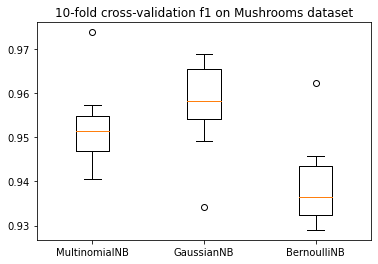

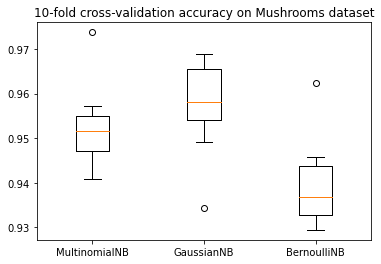

In [20]:
#The data is split into a 75/25 train test split.
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)

#We define the models to be used for the experiment, for this case it is all three Naive Bayes models. 
models = []
models.append(('MultinomialNB', MultinomialNB()))
models.append(('GaussianNB', GaussianNB()))
models.append(('BernoulliNB', BernoulliNB()))

#Iterate over each model and train using 10 fold cross validation on the mushroom dataset. Store the f1 and accuracy scores to be plotted.
f1_results = []
accuracy_results = []
names = []
for name, model in models:
    kfold = StratifiedKFold(n_splits=10, random_state=1)
    results = cross_validate(model, X_train, Y_train, cv=kfold, scoring = {'accuracy' : make_scorer(accuracy_score),
           'f1_score' : make_scorer(f1_score, average = 'weighted')})

    cv_f1_results = results['test_f1_score']
    cv_accuracy_results = results['test_accuracy']

    accuracy_results.append(cv_accuracy_results)
    f1_results.append(cv_f1_results)

    names.append(name)
    #Print the obtained scores.
    print('Accuracy: %s: %f (%f)' % (name, cv_accuracy_results.mean(), cv_accuracy_results.std()))
    print('F1 Weighted: %s: %f (%f)' % (name, cv_f1_results.mean(), cv_f1_results.std()))

#Plot f1 and accuracy box plots to illustrate model performance on the mushroom data.
pyplot.boxplot(f1_results, labels=names)
pyplot.title('10-fold cross-validation f1 on Mushrooms dataset')
pyplot.show()

pyplot.boxplot(accuracy_results, labels=names)
pyplot.title('10-fold cross-validation accuracy on Mushrooms dataset')
pyplot.show()

# Feature Selection
As with the wine dataset, feature selection can be performed using chi squared or mutual information models. 

Best features found for MultinomialNB using Chi-Squared feature selection: gill-size_n gill-color_b odor_f odor_n stalk-surface-above-ring_k stalk-surface-below-ring_k.
F1 Score: 0.9737346652675543 (0.0032917286426031723)
Accuracy: 0.9737398045707824 (0.0032878933980168236)


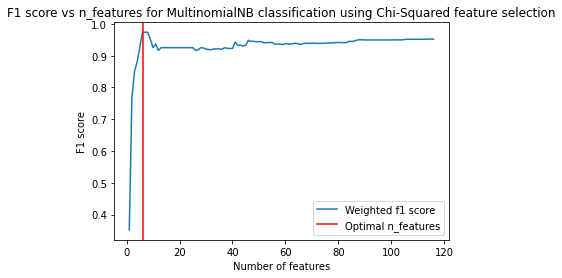

In [ ]:
#The tests will involve using 1 to all fields in the mushroom dataset. 
feature_tests = range(1,len(mushroomsNew.columns))

#Define the models to use and their respective datasets. In this case, they all use the same mushroomsNew dataset.
models = []
models.append(('MultinomialNB', MultinomialNB(), mushroomsNew))
models.append(('GaussianNB', GaussianNB(), mushroomsNew))
models.append(('BernoulliNB', BernoulliNB(), mushroomsNew))

#Define the feature selection methods to trial.
feature_selection_models = []
feature_selection_models.append(('Chi-Squared',chi2))
feature_selection_models.append(('Mutual Information',mutual_info_classif))

#Iterate over each model and respective dataset
for name, model, dataset in models:
    
    #Iterate over each feature selection model
    for fsname, fsmodel in feature_selection_models:
        
        results = []
        best_f1 = np.zeros(1)
        best_accuracy = np.zeros(1)
        best_features = []
        
        #For each test, train models using 10 fold cross validation with between 1 and 12 features included 
        #and store the best obtained f1 score and accuracy to output to the user. 
        for n_features in feature_tests:
            X = dataset.drop(['class'], axis=1)
            y = dataset['class']
            X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)
            X_train_fs, X_test_fs, features = select_features(X_train, Y_train, X_validation, fsmodel, n_features)
            kfold = StratifiedKFold(n_splits=10, random_state=1)
            scores = cross_validate(model, X_train_fs, Y_train, cv=kfold, scoring = {'accuracy' : make_scorer(accuracy_score), 
                   'precision' : make_scorer(precision_score, average = 'weighted'),
                   'recall' : make_scorer(recall_score, average = 'weighted'), 
                   'f1_score' : make_scorer(f1_score, average = 'weighted')})

            f1 = scores['test_f1_score']
            accuracy = scores['test_accuracy']

            if f1.mean()>best_f1.mean():
                best_f1 = f1
                best_features = features
                best_accuracy = accuracy
                
            results.append((features,f1))
      
        #Print the best obtained metrics and the features used to achieve this. 
        print('Best features found for '+ name +' using '+  fsname+' feature selection: ' + " ".join(best_features) + ".")
        print('F1 Score: ' + str(best_f1.mean()) + " (" + str(best_f1.std()) + ")")
        print('Accuracy: ' + str(best_accuracy.mean())+ " (" + str(best_accuracy.std()) + ")")

        
        #Plot how the f1 score changes as the number of included features change.
        results = list(zip(*results))
        plot_x = list(range(1,len(mushroomsNew.columns)))
        plot_y = [x.mean() for x in results[1]]
        
        plt.figure()
        plt.plot(plot_x, plot_y, label='Weighted f1 score')  
        plt.axvline(x=len(best_features), color = 'r', label='Optimal n_features')

        plt.xlabel("Number of features")
        plt.ylabel("F1 score")
        plt.title("F1 score vs n_features for "+ name +" classification using "+ fsname +" feature selection")
        plt.legend()
        plt.show()

## Mushroom Testing

## Multinomial Naive Bayes

In [ ]:
#Train a Multinomial naive bayes model on the full train set using the optimised dataset and evaluate against the test set. 

model = MultinomialNB()
dataset = mushroomsNew
X = dataset.drop(['class'], axis=1)
y = dataset['class']
X = X[['gill-size_n',
 'gill-color_b',
 'odor_f',
 'odor_n',
 'stalk-surface-above-ring_k',
 'stalk-surface-below-ring_k']]

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)

model.fit(X_train, Y_train)

y_pred = model.predict(X_validation)

f1 = f1_score(y_pred, Y_validation, average='weighted')
accuracy =  accuracy_score(y_pred, Y_validation)   

print('F1 Score: ' + str(f1))
print('Accuracy: ' + str(accuracy))

## Gaussian Naive Bayes

In [ ]:
#Train a Gaussian naive bayes model on the full train set using the optimised dataset and evaluate against the test set. 
model = GaussianNB()
dataset = mushroomsNew
X = dataset.drop(['class'], axis=1)
y = dataset['class']
X = X[['cap-shape_b',
 'cap-surface_f',
 'bruises_f',
 'bruises_t',
 'gill-spacing_w',
 'gill-size_b',
 'gill-size_n',
 'gill-color_b',
 'gill-color_n',
 'gill-color_u',
 'gill-color_w',
 'stalk-root_?',
 'stalk-root_c',
 'stalk-root_e',
 'odor_a',
 'odor_c',
 'odor_f',
 'odor_l',
 'odor_n',
 'odor_p',
 'odor_s',
 'odor_y',
 'stalk-surface-above-ring_k',
 'stalk-surface-above-ring_s',
 'stalk-surface-below-ring_k',
 'stalk-surface-below-ring_s',
 'stalk-color-above-ring_b',
 'stalk-color-above-ring_g',
 'stalk-color-above-ring_n',
 'stalk-color-above-ring_p',
 'stalk-color-below-ring_b',
 'stalk-color-below-ring_g',
 'stalk-color-below-ring_n',
 'stalk-color-below-ring_p',
 'ring-number_t',
 'ring-type_e',
 'ring-type_l',
 'ring-type_p',
 'spore-print-color_h',
 'spore-print-color_k',
 'spore-print-color_n',
 'spore-print-color_w',
 'population_a',
 'population_n',
 'population_v',
 'habitat_p']]

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)

model.fit(X_train, Y_train)

y_pred = model.predict(X_validation)

f1 = f1_score(y_pred, Y_validation, average='weighted')
accuracy =  accuracy_score(y_pred, Y_validation)   

print('F1 Score: ' + str(f1))
print('Accuracy: ' + str(accuracy))

## Bernoulli Naive Bayes

In [ ]:
#Train a Bernoulli naive bayes model on the full train set using the optimised dataset and evaluate against the test set. 
model = BernoulliNB()
dataset = mushroomsNew
X = dataset.drop(['class'], axis=1)
y = dataset['class']
X = X[['gill-size_n',
 'gill-color_b',
 'odor_f',
 'odor_n',
 'stalk-surface-above-ring_k',
 'stalk-surface-below-ring_k',
 'spore-print-color_h']]

X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.25, random_state=0)

model.fit(X_train, Y_train)

y_pred = model.predict(X_validation)

f1 = f1_score(y_pred, Y_validation, average='weighted')
accuracy =  accuracy_score(y_pred, Y_validation)   

print('F1 Score: ' + str(f1))
print('Accuracy: ' + str(accuracy))